In [56]:
from toolz import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
# %matplotlib widget


import pathlib
from lenses import lens

from collections import Counter

import re
import nltk
import pymorphy2
import fasttext.util

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

import pickle

### Все нужные данные переводим в pickle

In [ ]:
dict_to_pickle = {
    'df_for_learning': df_for_learning,
    'all_courses': all_courses,
    'inverse_cuisines_groups': inverse_cuisines_groups
}

## Подготовка BoE

In [159]:
data = np.array(df_for_learning['ingredient_embedding'])
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

## Обучение BoE

In [160]:
sequence_input = layers.Input(shape=(dim,), dtype='int32')
x = layers.Dense(64, activation='relu')(sequence_input)
x = layers.Dense(16, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)

model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [161]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 102)]             0         
                                                                 
 dense_27 (Dense)            (None, 64)                6592      
                                                                 
 dense_28 (Dense)            (None, 16)                1040      
                                                                 
 dense_29 (Dense)            (None, 9)                 153       
                                                                 
Total params: 7,785
Trainable params: 7,785
Non-trainable params: 0
_________________________________________________________________


In [162]:
EPOCHS = 20
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=EPOCHS, batch_size=128)

Epoch 1/20
259/259 [==============================] - 1s 3ms/step - loss: 1.7390 - accuracy: 0.4187 - val_loss: 1.5825 - val_accuracy: 0.4542
Epoch 2/20
259/259 [==============================] - 1s 2ms/step - loss: 1.5385 - accuracy: 0.4678 - val_loss: 1.5233 - val_accuracy: 0.4698
Epoch 3/20
259/259 [==============================] - 1s 2ms/step - loss: 1.5038 - accuracy: 0.4750 - val_loss: 1.5056 - val_accuracy: 0.4763
Epoch 4/20
259/259 [==============================] - 1s 2ms/step - loss: 1.4879 - accuracy: 0.4809 - val_loss: 1.5026 - val_accuracy: 0.4795
Epoch 5/20
259/259 [==============================] - 1s 2ms/step - loss: 1.4775 - accuracy: 0.4841 - val_loss: 1.5009 - val_accuracy: 0.4773
Epoch 6/20
259/259 [==============================] - 1s 2ms/step - loss: 1.4698 - accuracy: 0.4838 - val_loss: 1.4903 - val_accuracy: 0.4816
Epoch 7/20
259/259 [==============================] - 1s 2ms/step - loss: 1.4640 - accuracy: 0.4849 - val_loss: 1.4857 - val_accuracy: 0.4824
Epoch 

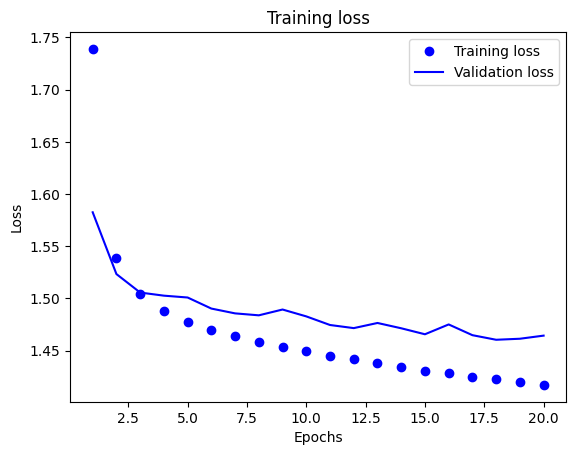

In [163]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

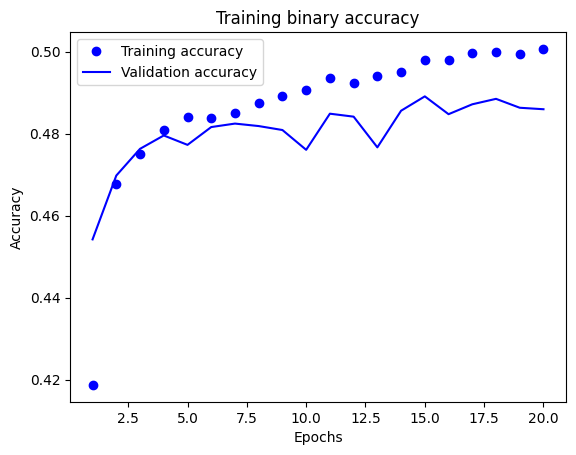

In [164]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Подготовка к CNN

In [165]:
data = lens.Each().Each().modify(lambda x: ingredients_numbering_dict[x])(ingredients_lemmatized)

In [166]:
data[:2]

[[1421, 1297, 204, 2187], [1124, 1323, 2338, 3615, 3469]]

In [167]:
data = pad_sequences(data, padding='post', value=0)
labels = to_categorical(np.array(df_for_learning['course_mark']), num_classes=len(all_courses))

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

VALIDATION_SPLIT = 0.2
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [168]:
max_length = len(data[0])
max_length

40

In [169]:
#Эта матрица будет использоваться для слоя Embedding в keras
ingredients_embeddings_matrix = np.zeros((len(all_ingredients_list), dim))
ingredients_embeddings_matrix.shape
for ingr in all_ingredients_list:
    ingredients_embeddings_matrix[ingredients_numbering_dict[ingr]] = ingredients_embeddings_dict[ingr]
ingredients_embeddings_matrix.shape

(4406, 102)

## Обучение CNN

In [171]:
embedding_layer = layers.Embedding(len(ingredients_embeddings_dict),
                            dim,
                            weights=[ingredients_embeddings_matrix],
                            input_length=max_length,
                            trainable=False)
# trainable=True позволит до обучаться эмбеддингам на нашем датасете

In [172]:
#первая архитектура CNN
# sequence_input = layers.Input(shape=(max_length,), dtype='int32')
# embedded_sequences = embedding_layer(sequence_input)
# x = layers.Conv1D(64, 2, activation='relu')(embedded_sequences)
# x = layers.GlobalMaxPool1D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(32, activation='relu')(x)
# preds = layers.Dense(len(all_courses), activation='softmax')(x)

#вторая архитектура CNN
sequence_input = layers.Input(shape=(max_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
arr = []
for i in [2,3,4]:
    x = layers.Conv1D(64, i, activation='relu')(embedded_sequences)
    arr.append(layers.GlobalMaxPool1D()(x))

x = layers.Concatenate()(arr)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
preds = layers.Dense(len(all_courses), activation='softmax')(x)



model = keras.Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [173]:
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 40, 102)      449412      ['input_18[0][0]']               
                                                                                                  
 conv1d_27 (Conv1D)             (None, 39, 64)       13120       ['embedding_5[0][0]']            
                                                                                                  
 conv1d_28 (Conv1D)             (None, 38, 64)       19648       ['embedding_5[0][0]']            
                                                                                           

In [ ]:
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

Epoch 1/20
259/259 [==============================] - 5s 19ms/step - loss: 0.5812 - accuracy: 0.7942 - val_loss: 0.8791 - val_accuracy: 0.6955
Epoch 2/20
259/259 [==============================] - 5s 18ms/step - loss: 0.5678 - accuracy: 0.7990 - val_loss: 0.8699 - val_accuracy: 0.7035
Epoch 3/20
259/259 [==============================] - 5s 19ms/step - loss: 0.5530 - accuracy: 0.8050 - val_loss: 0.8954 - val_accuracy: 0.6960
Epoch 4/20
259/259 [==============================] - 5s 19ms/step - loss: 0.5428 - accuracy: 0.8092 - val_loss: 0.9602 - val_accuracy: 0.6922
Epoch 5/20
259/259 [==============================] - 5s 20ms/step - loss: 0.5330 - accuracy: 0.8130 - val_loss: 0.8851 - val_accuracy: 0.7021
Epoch 6/20
259/259 [==============================] - 5s 20ms/step - loss: 0.5216 - accuracy: 0.8154 - val_loss: 0.9179 - val_accuracy: 0.7017
Epoch 7/20
259/259 [==============================] - 5s 20ms/step - loss: 0.5113 - accuracy: 0.8212 - val_loss: 0.9083 - val_accuracy: 0.6969

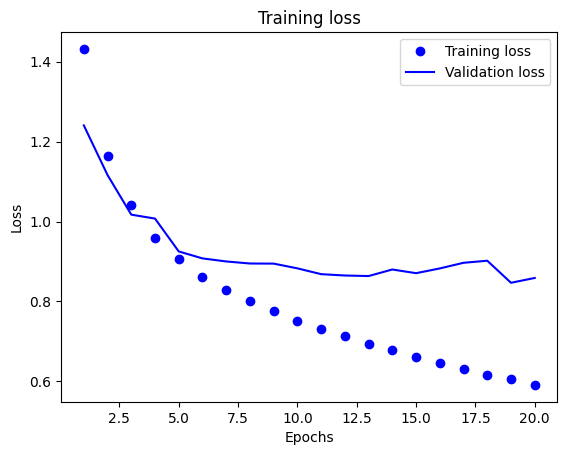

In [175]:
loss = H.history['loss'] 
val_loss = H.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

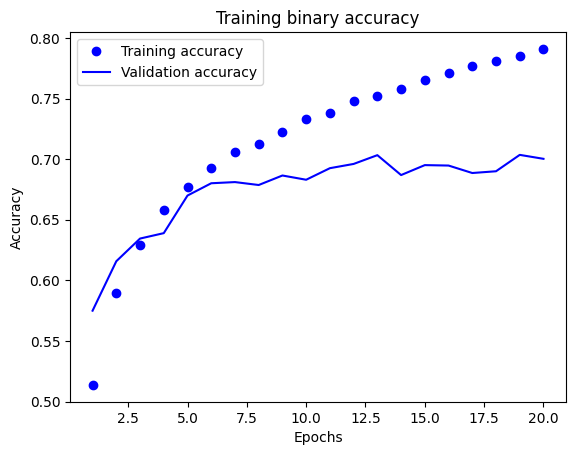

In [176]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Прочее:

In [45]:
it = df.groupby('cuisine').count()
it.sort_values('title', ascending=False).head(30)

,id,title,course,ingredients
cuisine,,,,
Европейская кухня,11699,11699,11699,11699
Русская кухня,7111,7111,7111,7111
Итальянская кухня,4943,4943,4943,4943
Французская кухня,3055,3055,3055,3055
Американская кухня,2192,2192,2192,2192
Авторская кухня,1822,1822,1822,1822
Китайская кухня,840,840,840,840
Греческая кухня,640,640,640,640
Мексиканская кухня,583,583,583,583


In [46]:
a = ft.get_word_vector('кокосовый')-ft.get_word_vector('кокосовое')+ft.get_word_vector('кремовое')-ft.get_word_vector('кремовый')
a@a

NameError: name 'ft' is not defined